In [94]:
pip install keras

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install pyswarm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4485 sha256=ff217abe590be570d24ec717d22f9f2df0bd02ab1f3938c4a06eec2d90e5e459
  Stored in directory: c:\users\kotas\appdata\local\pip\cache\wheels\bb\4f\ec\8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm
Note: you may need to restart the kernel to use updated packages.


In [166]:
pip install optuna


  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/15/da/68883911855d8b4d521f9a370e4e6aab8232b91c1d8d5a8348c4680c6642/optuna-3.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/7f/50/9fb3a5c80df6eb6516693270621676980acd6d5a9a7efdbfa273f8d616c7/alembic-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/c6/c9/9cd84cbd5816aa8bee5fd5a00f857efd636ec30586848d571b67baf0b868/Mako-1.3.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ----------- ---------------------------- 112.6/380.1 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------  378.9/

In [167]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyswarm import pso
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import optuna

In [100]:
spark = SparkSession.builder \
    .appName("BDP_Project") \
    .getOrCreate()

trainDf = spark.read.csv('CMAPSS/train_FD001.txt', header=None,sep=" ",inferSchema=True)
testDf = spark.read.csv('CMAPSS/test_FD001.txt', header=None,sep=" ",inferSchema=True )
rulDf = spark.read.csv('CMAPSS/RUL_FD001.txt', header=None,sep=" ",inferSchema=True )
trainDf.describe().show()



+-------+------------------+------------------+--------------------+--------------------+-----+-----------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------+-----+-------------------+-------------------+----+----+
|summary|               _c0|               _c1|                 _c2|                 _c3|  _c4|              _c5|               _c6|               _c7|              _c8|               _c9|                _c10|              _c11|               _c12|              _c13|             _c14|               _c15|              _c16|              _c17|              _c18|               _c19|                _c20|              _c21|  _c22| _c23|               _c24|               _c25|_c26|_c27|
+-------+------------------+

In [101]:
pandasTrainDf = trainDf.toPandas()
pandasTrainDf.head()


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,None,None
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,None,None
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,None,None
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,None,None
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,None,None


In [102]:
pandasTestDf = testDf.toPandas()
pandasTestDf.head()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,None,None
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,None,None
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,None,None
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,None,None
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,None,None


In [103]:
pandasRulDf = rulDf.toPandas()
pandasRulDf.head()

,_c0,_c1
0,112,None
1,98,None
2,69,None
3,82,None
4,91,None


In [104]:
nullValuesPerColumn = pandasTrainDf.isnull().sum()
print("Null values per column:")
print(nullValuesPerColumn)

totalRows = len(pandasTrainDf)
print(f"\nTotal number of rows: {totalRows}")

Null values per column:
_c0         0
_c1         0
_c2         0
_c3         0
_c4         0
_c5         0
_c6         0
_c7         0
_c8         0
_c9         0
_c10        0
_c11        0
_c12        0
_c13        0
_c14        0
_c15        0
_c16        0
_c17        0
_c18        0
_c19        0
_c20        0
_c21        0
_c22        0
_c23        0
_c24        0
_c25        0
_c26    20631
_c27    20631
dtype: int64

Total number of rows: 20631


In [105]:
nullValuesPerColumn = pandasTestDf.isnull().sum()
print("Null values per column:")
print(nullValuesPerColumn)

totalRows = len(pandasTestDf)
print(f"\nTotal number of rows: {totalRows}")

Null values per column:
_c0         0
_c1         0
_c2         0
_c3         0
_c4         0
_c5         0
_c6         0
_c7         0
_c8         0
_c9         0
_c10        0
_c11        0
_c12        0
_c13        0
_c14        0
_c15        0
_c16        0
_c17        0
_c18        0
_c19        0
_c20        0
_c21        0
_c22        0
_c23        0
_c24        0
_c25        0
_c26    13096
_c27    13096
dtype: int64

Total number of rows: 13096


In [106]:
nullValuesPerColumn = pandasRulDf.isnull().sum()
print("Null values per column:")
print(nullValuesPerColumn)

totalRows = len(pandasRulDf)
print(f"\nTotal number of rows: {totalRows}")

Null values per column:
_c0      0
_c1    100
dtype: int64

Total number of rows: 100


In [107]:
pandasRulDf['newColumn'] = range(1,101)
pandasRulDf.drop(columns=['_c1'],inplace=True)
pandasRulDf.head()

,_c0,newColumn
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [108]:
pandasRulDf = pandasRulDf.rename(columns={'newColumn':'unitNumber','_c0':'TRUE_RUL'})
newColumnOrder = ['unitNumber','TRUE_RUL']
pandasRulDf.reindex(columns = newColumnOrder)
pandasRulDf.head()

,TRUE_RUL,unitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [109]:
pandasTrainDf.drop(columns=['_c26','_c27'],inplace=True)
pandasTestDf.drop(columns=['_c26','_c27'],inplace=True)

In [110]:
pandasTrainDf.head()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [111]:
pandasTestDf.head()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [112]:
pandasTrainDf.describe()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [113]:
pandasTestDf.describe()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,-0.000000,-0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [114]:
newColumnNames= ['unitNumber', 'timeInCycles'] + \
                ['setting1', 'setting2', 'setting3'] + \
                ['sensor'+str(i) for i in range(1, 22)]
pandasTrainDf.columns = newColumnNames
pandasTestDf.columns = newColumnNames

In [115]:
pandasTrainDf.head()

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [116]:
max_cycles_df = pandasTrainDf.groupby('unitNumber')['timeInCycles'].max().reset_index(name='maxCycle')
pandasTrainDf = pandasTrainDf.merge(max_cycles_df, on='unitNumber', how='left')
pandasTrainDf['RUL'] = pandasTrainDf['maxCycle'] - pandasTrainDf['timeInCycles']
pandasTrainDf.drop('maxCycle', axis=1, inplace=True)
pandasTrainDf.head()

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


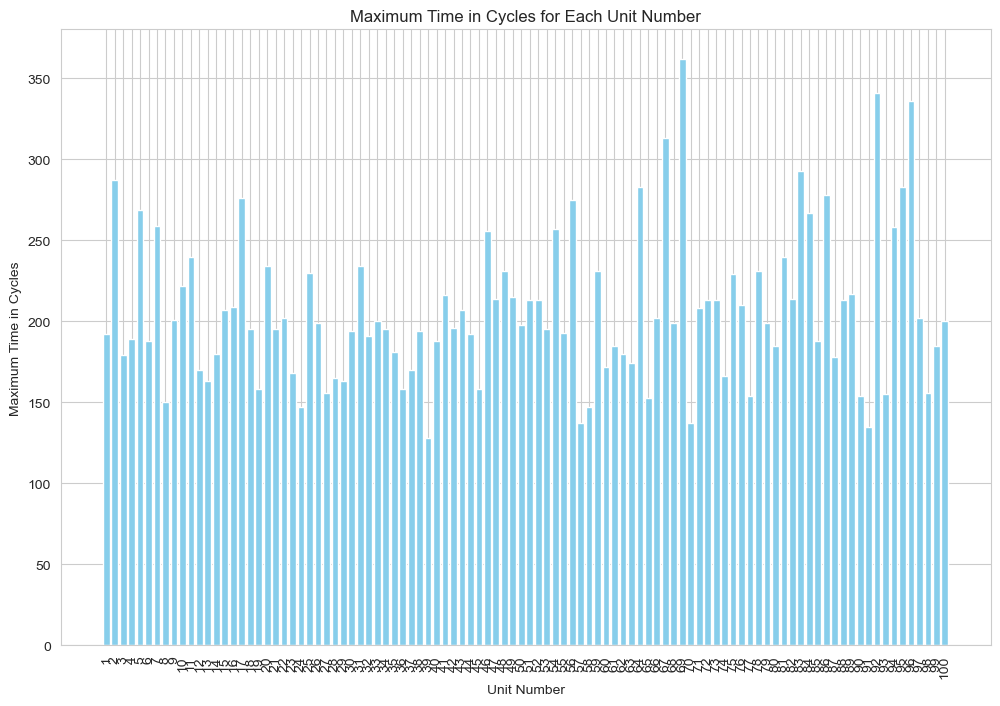

In [117]:
maxCyclesPerUnit = pandasTrainDf.groupby('unitNumber')['timeInCycles'].max().reset_index()

plt.figure(figsize=(12, 8))
plt.bar(maxCyclesPerUnit['unitNumber'].astype(str), maxCyclesPerUnit['timeInCycles'], color='skyblue')
plt.xlabel('Unit Number')
plt.ylabel('Maximum Time in Cycles')
plt.title('Maximum Time in Cycles for Each Unit Number')
plt.xticks(rotation=90)  
plt.show()


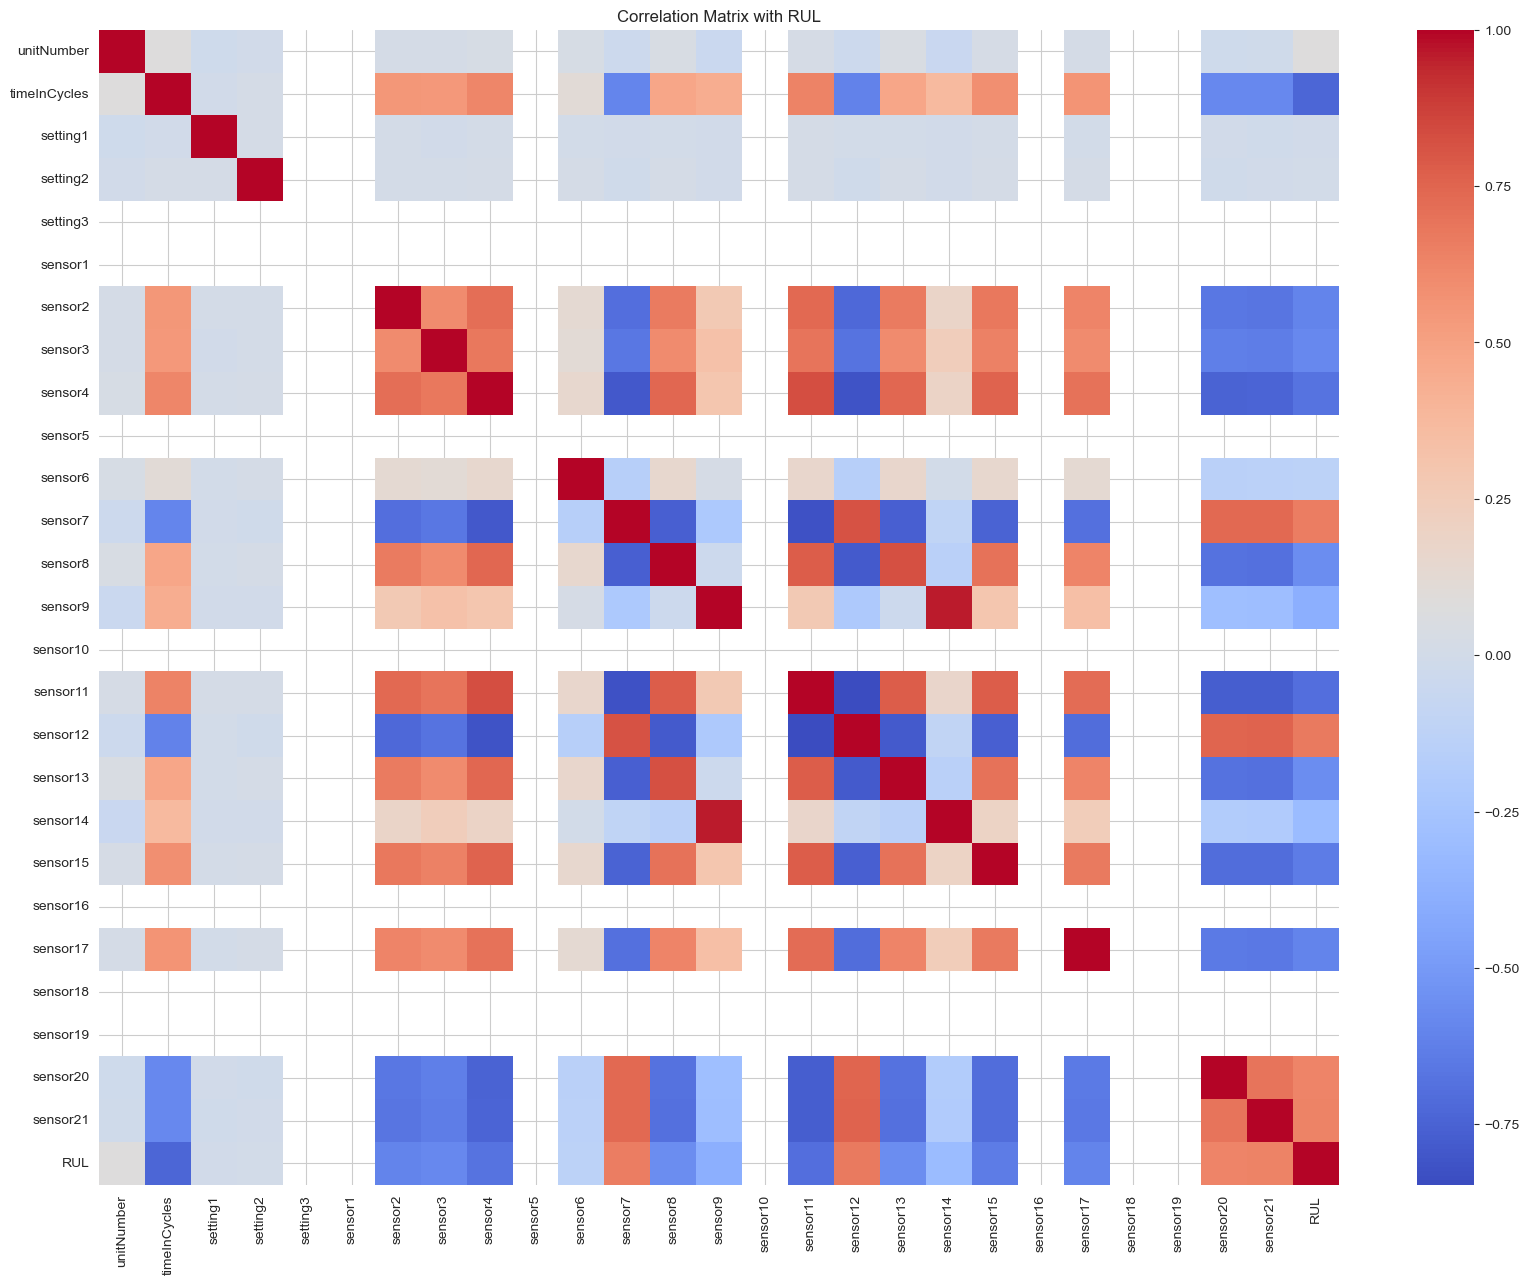

In [119]:
corrMatrix = pandasTrainDf.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corrMatrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix with RUL')
plt.show()

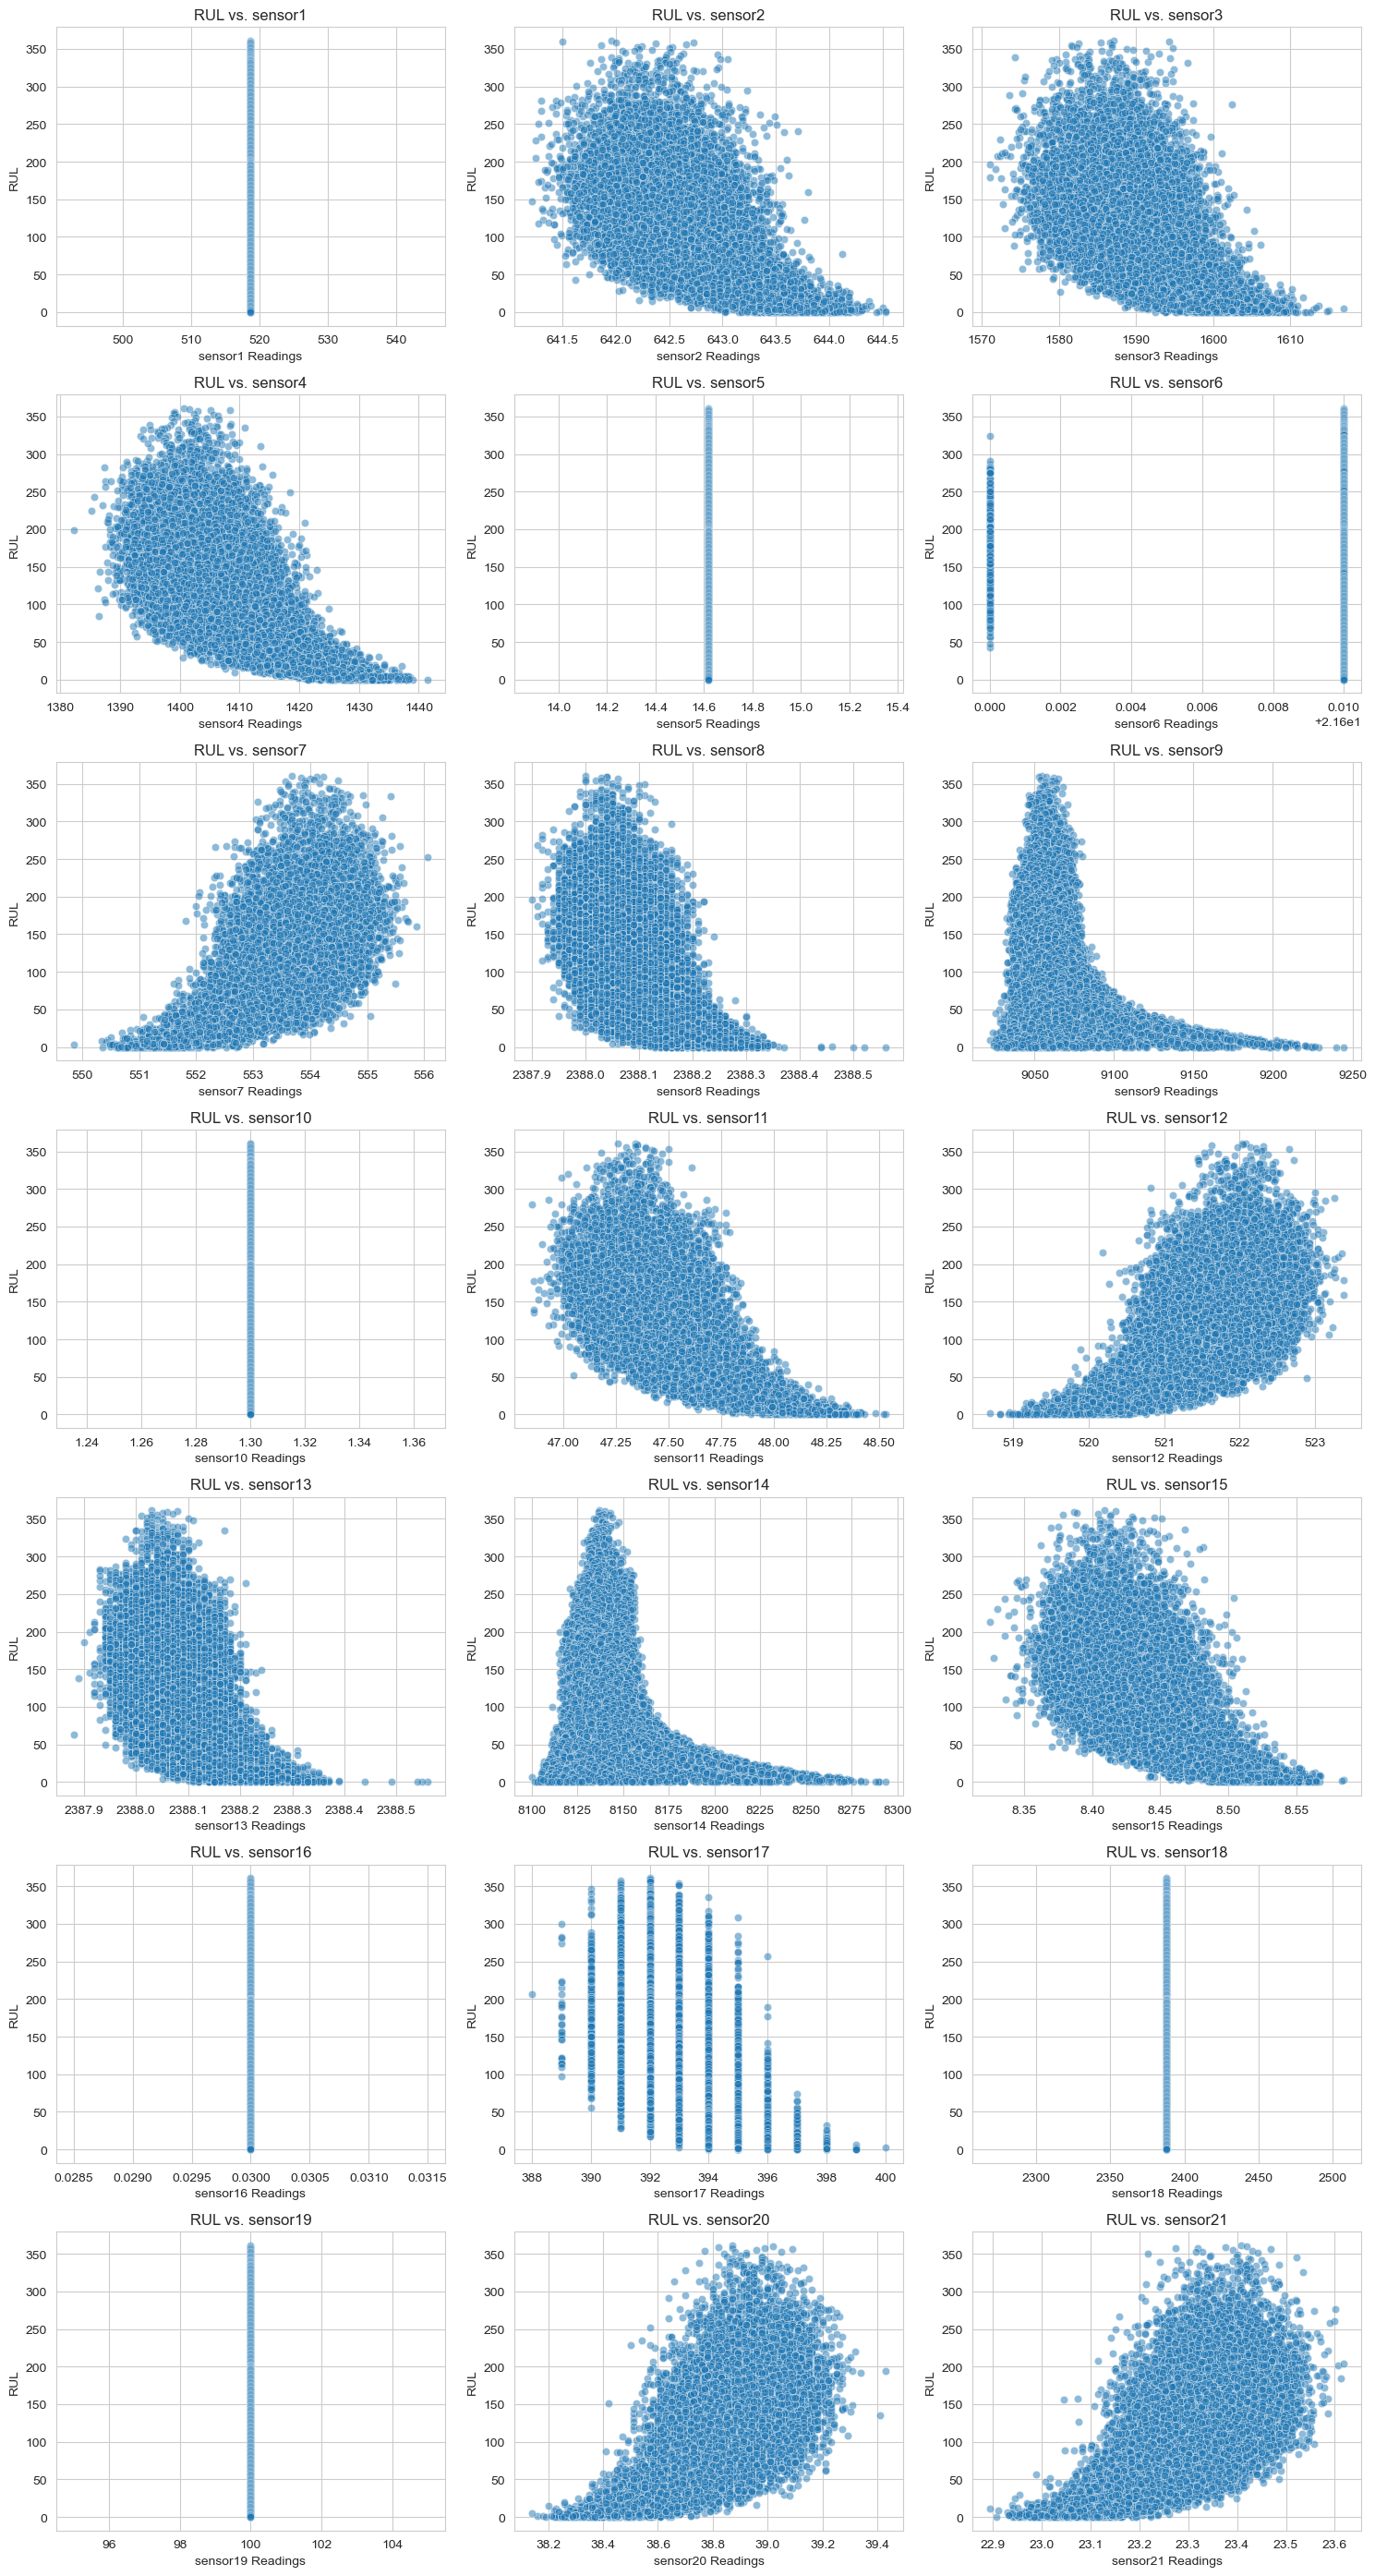

In [120]:
sensorColumns = ['sensor'+str(i) for i in range(1, 22)]
sensors = len(sensorColumns)  
cols = 3
rows = sensors // cols + (sensors % cols > 0)

plt.figure(figsize=(cols * 5, rows * 4)) 
for i, sensor in enumerate(sensorColumns, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(x=sensor, y='RUL', data=pandasTrainDf, alpha=0.5)
    plt.title(f'RUL vs. {sensor}')
    plt.xlabel(f'{sensor} Readings')
    plt.ylabel('RUL')
    plt.tight_layout()

plt.show()

In [121]:
normalizeCOlumns = ['setting1', 'setting2', 'setting3'] + ['sensor'+str(i) for i in range(1, 22)]
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler1.fit(pandasTrainDf[normalizeCOlumns])
scaler2.fit(pandasTestDf[normalizeCOlumns])

pandasTrainDf[normalizeCOlumns] = scaler1.transform(pandasTrainDf[normalizeCOlumns])
pandasTestDf[normalizeCOlumns] = scaler2.transform(pandasTestDf[normalizeCOlumns])

pandasTrainDf.head()

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [122]:
pandasTestDf

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.534247,0.325581,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.634703,0.395349,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.591324,0.325581,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.456621,0.372093,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.632420,0.325581,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.81875,0.461538,0.0,0.0,0.665615,0.789665,0.641209,0.0,...,0.299087,0.255814,0.935703,0.664909,0.0,0.625,0.0,0.0,0.309091,0.370842
13092,100,195,0.44375,0.384615,0.0,0.0,0.659306,0.692028,0.769042,0.0,...,0.381279,0.465116,0.914003,0.567593,0.0,0.750,0.0,0.0,0.236364,0.483652
13093,100,196,0.47500,0.230769,0.0,0.0,0.728707,0.626071,0.458036,0.0,...,0.410959,0.348837,0.971066,0.594919,0.0,0.750,0.0,0.0,0.281818,0.381741
13094,100,197,0.27500,0.538462,0.0,0.0,0.671924,0.673851,0.714111,0.0,...,0.445205,0.441860,1.000000,0.662991,0.0,0.750,0.0,0.0,0.318182,0.473461


In [123]:
pandasTestDf.shape

(13096, 26)

In [124]:
trainDf = pandasTrainDf.copy()
testDf = pandasTestDf.copy()
rulDf = pandasRulDf.copy()

In [125]:
windowSize = 10
shift = 1
X_train = []
y_train = []

for unitNumber in trainDf['unitNumber'].unique():
    unitData = trainDf[trainDf['unitNumber'] == unitNumber]

    features = unitData.drop(columns='RUL')

    numRows = len(unitData)
    if numRows >= windowSize:
        for i in range(0, numRows - windowSize + 1, shift):
            X_train.append(features.iloc[i:i+windowSize].values)  
            y_train.append(unitData.iloc[i+windowSize-1]['RUL'])
    else:
        X_train.append(features.values) 
        y_train.append(unitData.iloc[numRows-1]['RUL']) 

X_train = np.array([np.array(xi) for xi in X_train]) 
y_train = np.array(y_train)


In [126]:
trainDf.head()

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [127]:
testDf.head()

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.534247,0.325581,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.634703,0.395349,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.591324,0.325581,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.456621,0.372093,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.632420,0.325581,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008


In [128]:
rulTrain = trainDf[['RUL']].copy()
rulTrain['unitNumber'] = trainDf['unitNumber']
X_train = trainDf.drop(columns = ['RUL']).copy()

rulTrain

,RUL,unitNumber
0,191,1
1,190,1
2,189,1
3,188,1
4,187,1
...,...,...
20626,4,100
20627,3,100
20628,2,100
20629,1,100


In [132]:

X_test = testDf.copy()

X_test

,unitNumber,timeInCycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.534247,0.325581,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.634703,0.395349,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.591324,0.325581,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.456621,0.372093,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.632420,0.325581,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.81875,0.461538,0.0,0.0,0.665615,0.789665,0.641209,0.0,...,0.299087,0.255814,0.935703,0.664909,0.0,0.625,0.0,0.0,0.309091,0.370842
13092,100,195,0.44375,0.384615,0.0,0.0,0.659306,0.692028,0.769042,0.0,...,0.381279,0.465116,0.914003,0.567593,0.0,0.750,0.0,0.0,0.236364,0.483652
13093,100,196,0.47500,0.230769,0.0,0.0,0.728707,0.626071,0.458036,0.0,...,0.410959,0.348837,0.971066,0.594919,0.0,0.750,0.0,0.0,0.281818,0.381741
13094,100,197,0.27500,0.538462,0.0,0.0,0.671924,0.673851,0.714111,0.0,...,0.445205,0.441860,1.000000,0.662991,0.0,0.750,0.0,0.0,0.318182,0.473461


In [133]:
def processTrainingData(dataset, rulDataset = None, window = 1, shift = 1):
    partitions = int(np.floor((len(dataset) - window) / shift)) + 1
    features = dataset.shape[1]

    processedData = np.repeat(np.nan, repeats = partitions * window * features).reshape(partitions, window, features)

    if rulDataset is None:
        for i in range(partitions):
            processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
            
        return processedData

    processedRul = np.repeat(np.nan, repeats = partitions)
    for i in range(partitions):
        processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        processedRul[i] = rulDataset[(shift * i + (window - 1))]

    return processedData, processedRul

In [134]:
def processTestingData(dataset, window, shift, testWindow = 1):
    maxPartitions = int(np.floor((len(dataset) - window) / shift)) + 1

    if maxPartitions < testWindow:
        newLen = (maxPartitions - 1) * shift + window

        processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

        return processedData, maxPartitions

    newLen = (testWindow - 1) * shift + window

    processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

    return processedData, testWindow

In [135]:
temp1 = []
temp2 = []
processedTrainDataset = []
processedTrainRulDataset=[]
defaultWindow = 10
defaultShift=1

for i in X_train['unitNumber'].unique():
    tempTrainDataset = X_train[X_train['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    window_size = min(len(tempTrainDataset), defaultWindow)
    
    tempTrainRulDataset = rulTrain[rulTrain['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window=window_size, shift=defaultShift)
    
    temp1.append(tempTrainDataset)
    temp2.append(tempTrainRulDataset)
    
processedTrainDataset = np.concatenate(temp1)
processedTrainRulDataset = np.concatenate(temp2)

processedTrainDataset.shape

(19731, 10, 25)

In [136]:
temp1 = []
temp2 = []
processedTestDataset=[]
defaultTestWindow=10

for i in X_test['unitNumber'].unique():
    tempTestDataset = X_test[X_test['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    window_size = min(len(tempTestDataset), defaultWindow)
    
    tempTestDataset, testWindow = processTestingData(tempTestDataset, window=window_size, shift=defaultShift, testWindow=defaultTestWindow)
    
    temp1.append(tempTestDataset)
    temp2.append(testWindow)
    
processedTestDataset = np.concatenate(temp1)
testWindowList = temp2


processedTestDataset.shape

(1000, 10, 25)

In [137]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True,
         input_shape=(processedTrainDataset.shape[1], processedTrainDataset.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [138]:
history = model.fit(processedTrainDataset,processedTrainRulDataset, epochs=30, validation_split = 0.2)

Epoch 1/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 6460.7949 - val_loss: 3012.4585
Epoch 2/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1389.8171 - val_loss: 2333.4778
Epoch 3/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 1202.1019 - val_loss: 2513.4312
Epoch 4/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 1157.0568 - val_loss: 2586.6345
Epoch 5/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 1171.7601 - val_loss: 2637.7952
Epoch 6/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 1154.7188 - val_loss: 2667.5081
Epoch 7/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1092.0680 - val_loss: 2544.4919
Epoch 8/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 1090.8307 - val_loss: 2366.1772
Epoch 9/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1111.6003 - val_loss: 2543.6836
Epoch 10/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1070.6421 - val_loss: 2837.3240
Epoch 11/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - lo

In [139]:
predictedRul = model.predict(processedTestDataset).reshape(-1)
predictedRul = np.split(predictedRul, np.cumsum(testWindowList)[:-1])
predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList)]
predictedRul

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


[152.47813110351564,
 142.2786071777344,
 14.20673236846924,
 28.77968673706055,
 33.01726169586182,
 47.31621932983399,
 71.1196434020996,
 35.99477844238282,
 134.9945991516113,
 45.97457351684571,
 41.57157802581788,
 65.56508789062501,
 48.29855499267579,
 147.7954818725586,
 113.56291046142577,
 86.73691101074219,
 22.304269218444823,
 21.05972366333008,
 63.74572601318359,
 6.361725330352783,
 47.40805969238281,
 154.25521392822267,
 94.04867172241212,
 7.762270069122315,
 137.07923126220703,
 114.11745376586916,
 68.56206512451172,
 42.09699783325196,
 43.89890975952148,
 29.888115119934085,
 5.7899390220642095,
 32.81248016357422,
 142.63169860839844,
 6.311715650558472,
 5.756850051879883,
 6.298757266998292,
 19.73696460723877,
 9.24624080657959,
 151.06123657226564,
 6.37349305152893,
 20.25102424621582,
 8.524924516677856,
 25.350496292114258,
 133.27255783081057,
 21.3511589050293,
 10.21217613220215,
 78.25700225830079,
 96.16306533813479,
 7.864306926727296,
 108.6576286

In [140]:
trueRul = rulDf['TRUE_RUL']

In [141]:
rmse = np.sqrt(mean_squared_error(trueRul, predictedRul))
print("RMSE:", rmse)

mae = mean_absolute_error(trueRul, predictedRul)
print("MAE:", mae)


RMSE: 36.35372908958433
MAE: 28.608463905811313


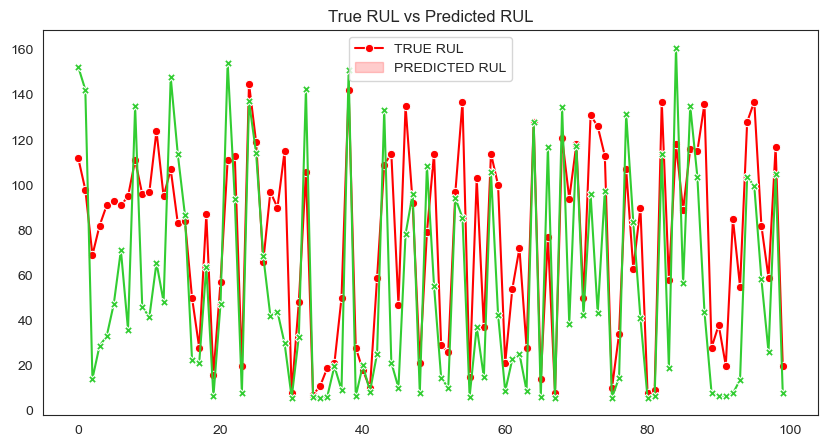

In [144]:
df = pd.DataFrame({
    'TRUE_RUL': trueRul,
    'PREDICTED_RUL': predictedRul
})

bright_colors = ['red', 'limegreen']  
sns.set_palette(sns.color_palette(bright_colors))
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, markers=True, dashes=False)  
plt.title('True RUL vs Predicted RUL')
plt.legend(labels=['TRUE RUL', 'PREDICTED RUL'])
plt.show()

## Using PCA to train the data and finding the forecast results 

In [145]:
featuresTrain = trainDf.drop(['unitNumber', 'timeInCycles', 'RUL'], axis=1)
featuresTest = testDf.drop(['unitNumber', 'timeInCycles'], axis=1)

pca = PCA(n_components=9)
pca.fit(featuresTrain)

trainPca = pca.transform(featuresTrain)
testPca = pca.transform(featuresTest)

trainDfPca = pd.DataFrame(trainPca, columns=[f'PC{i+1}' for i in range(9)])
trainDfPca['unitNumber'] = trainDf['unitNumber']
trainDfPca['timeInCycles'] = trainDf['timeInCycles']
trainDfPca['RUL'] = trainDf['RUL']

testDfPca = pd.DataFrame(testPca, columns=[f'PC{i+1}' for i in range(9)])
testDfPca['unitNumber'] = testDf['unitNumber']
testDfPca['timeInCycles'] = testDf['timeInCycles']

In [146]:
rulTrainPca = trainDfPca[['RUL']].copy()
rulTrainPca['unitNumber'] = trainDfPca['unitNumber']
X_train_pca = trainDfPca.drop(columns = ['RUL']).copy()
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,unitNumber,timeInCycles
0,-0.410290,0.329588,-0.062926,-0.034272,0.039837,0.150101,-0.061206,-0.044378,-0.039456,1,1
1,-0.334079,0.245318,-0.083213,-0.020121,-0.109669,0.088208,-0.113706,-0.072674,-0.013043,1,2
2,-0.415501,-0.251669,-0.054831,-0.033593,0.246061,-0.010257,-0.056753,0.078662,0.145056,1,3
3,-0.517311,-0.005695,-0.087794,-0.027715,-0.042761,-0.058995,0.027378,0.043045,0.011939,1,4
4,-0.345767,0.164130,-0.043195,-0.036834,0.104798,-0.030646,0.082129,-0.092327,-0.030043,1,5
...,...,...,...,...,...,...,...,...,...,...,...
20626,0.982341,0.263587,-0.082210,0.061408,0.022039,0.032126,0.106864,0.125273,-0.088176,100,196
20627,0.998340,0.430238,-0.094181,0.062383,0.095656,0.053460,-0.070816,-0.122285,0.134580,100,197
20628,1.127928,0.014627,-0.039194,0.060573,-0.021783,0.121446,0.100898,0.076342,-0.110534,100,198
20629,1.110000,-0.234838,-0.066442,0.066932,0.070271,0.171857,-0.007462,-0.038330,0.150667,100,199


In [147]:
X_test_pca = testDfPca.copy()


In [148]:
temp1 = []
temp2 = []
processedTrainDatasetPca = []
processedTrainRulDatasetPca=[]
defaultWindow = 10
defaultShift=1

for i in X_train_pca['unitNumber'].unique():
    tempTrainDataset = X_train_pca[X_train_pca['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    window_size = min(len(tempTrainDataset), defaultWindow)
    
    tempTrainRulDataset = rulTrainPca[rulTrainPca['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window=window_size, shift=defaultShift)
    
    temp1.append(tempTrainDataset)
    temp2.append(tempTrainRulDataset)
    
processedTrainDatasetPca = np.concatenate(temp1)
processedTrainRulDatasetPca = np.concatenate(temp2)

processedTrainDatasetPca.shape

(19731, 10, 10)

In [149]:
temp1 = []
temp2 = []
processedTestDatasetPca=[]
defaultTestWindow=10

for i in X_test_pca['unitNumber'].unique():
    tempTestDataset = X_test_pca[X_test_pca['unitNumber'] == i].drop(columns=['unitNumber']).values
    
    window_size = min(len(tempTestDataset), defaultWindow)
    
    tempTestDataset, testWindow = processTestingData(tempTestDataset, window=window_size, shift=defaultShift, testWindow=defaultTestWindow)
    
    temp1.append(tempTestDataset)
    temp2.append(testWindow)
    
processedTestDatasetPca = np.concatenate(temp1)
testWindowListPca = temp2

processedTestDatasetPca.shape

(1000, 10, 10)

In [150]:
model_pca = Sequential([
    LSTM(128, activation='tanh', return_sequences=True,
         input_shape=(processedTrainDatasetPca.shape[1], processedTrainDatasetPca.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model_pca.compile(optimizer='adam', loss='mean_squared_error')


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [151]:
history_pca = model_pca.fit(processedTrainDatasetPca,processedTrainRulDatasetPca, epochs=30, validation_split = 0.2)

Epoch 1/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 5848.7197 - val_loss: 3153.7583
Epoch 2/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 1443.7714 - val_loss: 2744.8789
Epoch 3/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1244.7532 - val_loss: 2671.4146
Epoch 4/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1150.7224 - val_loss: 2655.8884
Epoch 5/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1150.8239 - val_loss: 2832.0933
Epoch 6/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1115.4043 - val_loss: 2522.8518
Epoch 7/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 1112.1895 - val_loss: 2506.5959
Epoch 8/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 1094.3785 - val_loss: 2725.0554
Epoch 9/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1121.8463 - val_loss: 2715.0286
Epoch 10/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 1123.2708 - val_loss: 2746.9712
Epoch 11/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - lo

In [152]:
predictedRulPca = model_pca.predict(processedTestDatasetPca).reshape(-1)
predictedRulPca = np.split(predictedRulPca, np.cumsum(testWindowListPca)[:-1])
predictedRulPca = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRulPca, testWindowListPca)]
predictedRulPca

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[152.24281311035156,
 140.74404296875,
 19.705495452880857,
 41.7346450805664,
 48.12891921997071,
 63.9403663635254,
 71.1966510772705,
 41.2476146697998,
 133.22077484130858,
 56.53258361816407,
 58.14755363464356,
 65.68622779846191,
 58.486909103393565,
 149.75480957031252,
 119.67691040039062,
 83.81671600341797,
 23.04403228759766,
 29.529163360595707,
 67.99525375366211,
 6.685103511810303,
 45.084661865234374,
 152.78550720214844,
 100.34132156372071,
 10.0228102684021,
 140.68840942382812,
 120.34448471069335,
 74.0408103942871,
 50.076323699951175,
 48.81855926513671,
 38.10601501464844,
 5.166038608551026,
 28.189488983154302,
 141.61811065673828,
 6.102110481262207,
 4.938021659851074,
 5.095737504959107,
 25.75701656341553,
 14.960369777679444,
 148.39458770751952,
 5.904504013061524,
 24.612343788146973,
 8.856996536254883,
 33.15698318481446,
 132.8138916015625,
 28.66112003326416,
 16.135054302215575,
 111.02460021972658,
 110.0162223815918,
 9.418545341491699,
 114.708

In [153]:
rmse = np.sqrt(mean_squared_error(trueRul, predictedRulPca))
print("RMSE with PCA features is :", rmse)

mae = mean_absolute_error(trueRul, predictedRulPca)
print("MAE with PCA features is :", mae)

RMSE with PCA features is : 32.706150721717336
MAE with PCA features is : 25.943271368026732


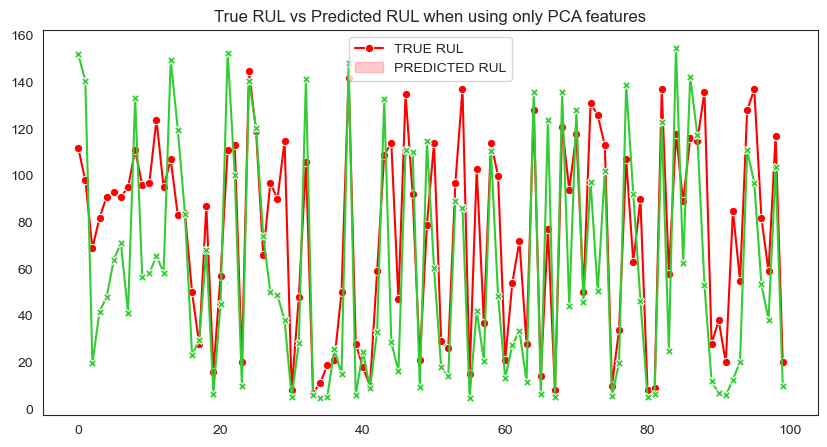

In [164]:
df = pd.DataFrame({
    'TRUE_RUL_PCA': trueRul,
    'PREDICTED_RUL_PCA': predictedRulPca
})
bright_colors = ['red', 'limegreen']  
sns.set_palette(sns.color_palette(bright_colors))
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, markers=True, dashes=False)  
plt.title('True RUL vs Predicted RUL when using only PCA features')
plt.legend(labels=['TRUE RUL', 'PREDICTED RUL'])
plt.show()

## Hyperparameter optimization using Optuna

In [168]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(processedTrainDatasetPca.shape[1], processedTrainDatasetPca.shape[2])),
        Dropout(dropout_rate),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(dropout_rate),
        LSTM(32, activation='tanh'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    history = model.fit(
        processedTrainDatasetPca, processedTrainRulDatasetPca, 
        epochs=10, 
        batch_size=batch_size, 
        validation_split=0.2, 
        verbose=0, 
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    best_val_loss = np.min(history.history['val_loss'])
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
best_loss = study.best_trial.value

print("Best hyperparameters found:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Dropout Rate: {best_params['dropout_rate']}")
print(f"Best validation loss: {best_loss}")


[I 2024-04-23 19:18:08,608] A new study created in memory with name: no-name-a12cf355-4fe9-4042-bb50-1ac42316b65a
C:\Users\kotas\AppData\Local\Temp\ipykernel_45140\1442777233.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)
C:\Users\kotas\AppData\Local\Temp\ipykernel_45140\1442777233.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first la

Best hyperparameters found:
Learning Rate: 0.0007779663580115545
Batch Size: 32
Dropout Rate: 0.16537527762893436
Best validation loss: 2194.945068359375


## Hyperparameter optimzation using PSO Algorithm

In [165]:
def optimize_lstm(x):
    learning_rate = x[0]
    batch_size = int(x[1])
    dropout_rate = x[2]
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(processedTrainDatasetPca.shape[1], processedTrainDatasetPca.shape[2])),
        Dropout(dropout_rate),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(dropout_rate),
        LSTM(32, activation='tanh'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')

    history = model.fit(processedTrainDatasetPca, processedTrainRulDatasetPca, epochs=10, batch_size=batch_size, 
                        validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    best_val_loss = np.min(history.history['val_loss'])
    return best_val_loss

lb = [0.0001,32, 0.1]  
ub = [0.01, 256, 0.5] 

xopt, fopt = pso(optimize_lstm, lb, ub, swarmsize=10, omega=0.5, phip=0.5, phig=0.5, maxiter=20, minstep=1e-8, minfunc=1e-8)

print("Best hyperparameters found:")
print(f"Learning Rate: {xopt[0]}")
print(f"Epochs: {int(xopt[1] * 10) * 2 + 10}")  
print(f"Batch Size: {int(xopt[2])}")
print(f"Dropout Rate: {xopt[3]}")
print(f"Best validation loss: {fopt}")

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

I tried to use the PSO algorithm to find the hyperparameters but my personal system is not well equipped. So after four hours of running the jupyter notebook chrome is shutting down automatically and I am not able to find the hyperparameters using the PSO algorithm

## To find optimum window size

In [160]:
def evaluate_window_size(window_size):
    temp1 = []
    temp2 = []

    for i in X_train_pca['unitNumber'].unique():
        tempTrainDataset = X_train_pca[X_train_pca['unitNumber'] == i].drop(columns=['unitNumber']).values
        tempTrainRulDataset = rulTrainPca[rulTrainPca['unitNumber'] == i].drop(columns=['unitNumber']).values
        
        tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window=window_size, shift=defaultShift)
        temp1.append(tempTrainDataset)
        temp2.append(tempTrainRulDataset)
    
    processedTrainDatasetPca = np.concatenate(temp1)
    processedTrainRulDatasetPca = np.concatenate(temp2)

    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(processedTrainDatasetPca.shape[1], processedTrainDatasetPca.shape[2])),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(processedTrainDatasetPca, processedTrainRulDatasetPca, epochs=10, validation_split=0.2, verbose=0)

    return np.min(history.history['val_loss'])

window_sizes = [10, 20, 30]
results = {}

for size in window_sizes:
    val_loss = evaluate_window_size(size)
    results[size] = val_loss
    print(f"Validation loss: {val_loss} for window size {size}")

best_window_size = min(results, key=results.get)
print(f"The best window size is: {best_window_size}")

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 2314.346923828125 for window size 10


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 2292.6064453125 for window size 20


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 2029.486328125 for window size 30
The best window size is: 30


# The below code is written before the project presentation and I have added the updated code above which gives the required results. Below code is used in the project presentation, so I just kept the below code. 


In [38]:
featuresTrain = trainDf.drop(['unitNumber', 'timeInCycles', 'RUL'], axis=1)
featuresTest = testDf.drop(['unitNumber', 'timeInCycles'], axis=1)

pca = PCA(n_components=9)
pca.fit(featuresTrain)

trainPca = pca.transform(featuresTrain)
testPca = pca.transform(featuresTest)

trainDfPca = pd.DataFrame(trainPca, columns=[f'PC{i+1}' for i in range(9)])
trainDfPca['unitNumber'] = trainDf['unitNumber']
trainDfPca['timeInCycles'] = trainDf['timeInCycles']
trainDfPca['RUL'] = trainDf['RUL']

testDfPca = pd.DataFrame(testPca, columns=[f'PC{i+1}' for i in range(9)])
testDfPca['unitNumber'] = testDf['unitNumber']
testDfPca['timeInCycles'] = testDf['timeInCycles']


In [39]:
def processTrainingDataPCA(dataset, window=1, shift=1):
    features = [f'PC{i+1}' for i in range(9)]
    return processSequenceData(dataset, features, window, shift, True)

def processTestDataPCA(dataset, window=1, shift=1):
    features = [f'PC{i+1}' for i in range(9)]
    return processSequenceData(dataset, features, window, shift, False)

def processSequenceData(dataset, features, window, shift, include_rul):
    uniqueUnits = dataset['unitNumber'].unique()
    X, y = [], []

    for unit in uniqueUnits:
        unitData = dataset[dataset['unitNumber'] == unit].sort_values(by='timeInCycles')
        numSequences = int(np.floor((len(unitData) - window) / shift)) + 1

        for seqStart in range(0, shift * numSequences, shift):
            seqEnd = seqStart + window
            if seqEnd <= len(unitData):
                X.append(unitData.iloc[seqStart:seqEnd][features].values)
                if include_rul:
                    y.append(unitData.iloc[seqEnd-1]['RUL'])

    if include_rul:
        return np.array(X), np.array(y)
    else:
        return np.array(X), None


In [138]:
window_size = 10
shift = 1

processedTrainDatasetPCA, processedTrainRulDatasetPCA = processTrainingDataPCA(trainDfPca, window=window_size, shift=shift)

processedTestDatasetPCA, _ = processTestDataPCA(testDfPca, window=window_size, shift=shift)

X_train, X_val, y_train, y_val = train_test_split(
    processedTrainDatasetPCA, processedTrainRulDatasetPCA, test_size=0.2, random_state=42
)

In [139]:
def create_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (processedTrainDatasetPCA.shape[1], processedTrainDatasetPCA.shape[2])
model_pca = create_model(input_shape)

model_pca.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)



D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 7908.4106
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1729.8042
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 1680.6569
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1670.7343
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1603.2550
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1593.1425
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1599.6847
Epoch 8/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1599.3534
Epoch 9/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1551.2703
Epoch 10/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1534.5309
Epoch 11/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1567.3588
Epoch 12/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1492.7045
Epoch 13/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1492.8887
Epoch 14/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1527.0105

In [143]:
y_pred = model_pca.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE is : {rmse}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE is : 35.58218440859708


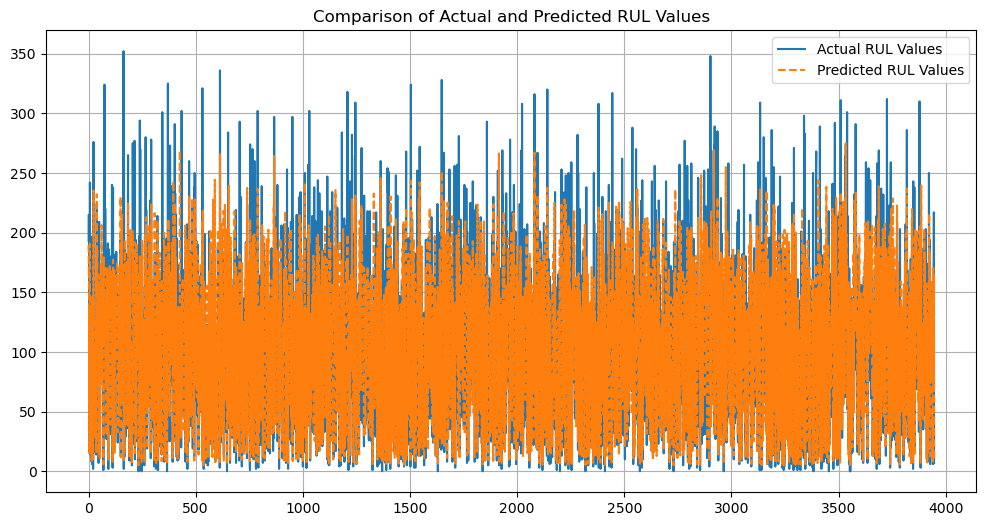

In [150]:

plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual RUL Values', linestyle='-') 
plt.plot(y_pred.flatten(), label='Predicted RUL Values', linestyle='--')
plt.title('Comparison of Actual and Predicted RUL Values')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
spark.stop()